# Poisson 3d

This script solves the 3d Poisson equation in the domain $\Omega=[0,1]\times[0,1]\times[0,1]$ in slab geometry using finite element exterior calculus:

\begin{align*}
    &\sigma=-\nabla u,\\
    &\nabla\cdot\sigma=f.
\end{align*}

Both Dirichlet $u(\partial\Omega)=0$ and periodic boundary conditions can be employed. We use the following weak formulation: Find $u\in H^1_0$ and $\sigma\in H(\mathrm{curl})$ such that

\begin{align*}
    &\int_\Omega\sigma\tau\,\mathrm{d}\Omega+\int_\Omega\nabla u\cdot\tau\,\mathrm{d}\Omega=0\qquad\forall\tau\in H(\mathrm{curl}),\\
    &-\int_\Omega\sigma\cdot\nabla v\,\mathrm{d}\Omega=\int_\Omega fv\,\mathrm{d}\Omega\qquad\forall v\in H^1_0.
\end{align*}

Note that we have integrated by parts in the second equation to get a well-defined weak formulation. Expanding trial and test functions as

\begin{align*}
    &u=\sum_{\mathbf{j}}u_{\mathbf{j}}\Lambda^0_{\mathbf{j}}(x,y,z), \qquad \sigma=\sum_{\mathbf{i}}\sum_{a=1}^3\sigma_{\mathbf{i},a}\Lambda^1_{\mathbf{i},a}(x,y,z),
\end{align*}

with the multi-indices $\mathbf{i}=(i_1,i_2,i_3)$ and $\mathbf{j}=(j_1,j_2,j_3)$ and basis functions

\begin{align*}
    &\Lambda^0_{\mathbf{j}}(x,y,z)=N_{j_1}(x)N_{j_2}(y)N_{j_3}(z),\\
    \\
    &\Lambda^1_{\mathbf{i},1}(x,y,z)=D_{i_1}(x)N_{i_2}(y)N_{i_3}(z),\\
    &\Lambda^1_{\mathbf{i},2}(x,y,z)=N_{i_1}(x)D_{i_2}(y)N_{i_3}(z),\\
    &\Lambda^1_{\mathbf{i},3}(x,y,z)=N_{i_1}(x)N_{i_2}(y)D_{i_3}(z).
\end{align*}

leads to the linear system

\begin{align*}
    &\begin{pmatrix}\mathbb{M}^1 &\mathbb{M}^1\mathbb{G}\\-\mathbb{G}^\top\mathbb{M}^1 &0\end{pmatrix}\begin{pmatrix}\boldsymbol{\sigma}\\ \mathbf{u}\end{pmatrix}=\begin{pmatrix}0\\\mathbf{f}^0\end{pmatrix}.
\end{align*}

In [1]:
import psydac.core.interface as inter
import numpy as np
import sympy as sym
import scipy.sparse as sparse
import matplotlib.pyplot as plt
import derivatives as der
import projectors as proj
import evaluation as eva
import integrate as integr
import time

In [2]:
# ... define boundary conditions in each direction (True: periodic, False: homogeneous Dirichlet)
bc = [False, False, False]
bc_x, bc_y, bc_z = bc

# ... length of computational domain in each direction
Lx = 1
Ly = 1
Lz = 1

# ... number of elements in each direction and corresponding element boundaries
Nel_x = 6
Nel_y = 6
Nel_z = 6

dx = Lx/Nel_x
dy = Ly/Nel_y
dz = Lz/Nel_z

el_b_x = np.linspace(0, Lx, Nel_x + 1)
el_b_y = np.linspace(0, Ly, Nel_y + 1)
el_b_z = np.linspace(0, Lz, Nel_z + 1)

# ... degree of spline basis (of the 0-forms) in each direction
p = [2, 2, 2]
px, py, pz = p

# ... number of basis functions
Nbase = [Nel_x + px, Nel_y + py, Nel_z + pz] 
Nbase_x, Nbase_y, Nbase_z = Nbase

# ... number of degrees of freedom
Nbase_x_0 = Nbase_x - bc_x*px - (1 - bc_x)*2
Nbase_y_0 = Nbase_y - bc_y*py - (1 - bc_y)*2
Nbase_z_0 = Nbase_z - bc_z*pz - (1 - bc_z)*2


# ... knot vectors
if bc_x == True:
    Tx = inter.make_periodic_knots(px, Nbase_x)
else:
    Tx = inter.make_open_knots(px, Nbase_x)
    
if bc_y == True:
    Ty = inter.make_periodic_knots(py, Nbase_y)
else:
    Ty = inter.make_open_knots(py, Nbase_y)
    
if bc_z == True:
    Tz = inter.make_periodic_knots(pz, Nbase_z)
else:
    Tz = inter.make_open_knots(pz, Nbase_z)
    
T = [Tx, Ty, Tz]


# ... discrete derivatives
GRAD = der.GRAD_3d(p, Nbase, bc)
CURL = der.CURL_3d(p, Nbase, bc)
DIV  = der.DIV_3d(p, Nbase, bc)

# ... mass matrices
M0 = integr.mass_matrix_V0(p, Nbase, T, bc_x)
M1 = integr.mass_matrix_V1(p, Nbase, T, bc_x)
M2 = integr.mass_matrix_V2(p, Nbase, T, bc_x)
M3 = integr.mass_matrix_V3(p, Nbase, T, bc_x)

In [3]:
class Poisson3d:
    """Exact solution to the 3d Poisson equation, to be employed for the method
    of manufactured solutions.
    """
    
    def __init__(self, bc, shift):
        self.bc = bc
        self.shift = shift
        
        if bc == True:
            shift = 0.

            x, y, z = sym.symbols('x, y, z')
            u = sym.sin(2*sym.pi*x)*sym.cos(2*sym.pi*y)*sym.sin(2*sym.pi*z) + shift

            f = - sym.diff(u, x, x) - sym.diff(u, y, y) - sym.diff(u, z, z)
            self._f = sym.lambdify((x, y, z), f)
            self._u = sym.lambdify((x, y, z), u)
            
        else:
            x, y, z = sym.symbols('x, y, z')
            u = x*sym.sin(2*sym.pi*x)*y*(1 - sym.cos(2*sym.pi*y))*z*sym.sin(2*sym.pi*z)

            f = -sym.diff(u, x, x) -sym.diff(u, y, y) - sym.diff(u, z, z)
            self._f = sym.lambdify((x, y, z), f)
            self._u = sym.lambdify((x, y, z), u)
            
    def u(self, x, y, z):
        return self._u(x, y, z)

    def f(self, x, y, z):
        return self._f(x, y, z)

In [13]:
# ... create model
model = Poisson3d(bc_x, 0)

# ... assemble right-hand-side (L2 scalar product over the space V0) and apply boundary conditions
rhs = integr.L2_prod_V0(model.f, p, Nbase, T)

if bc == True:
    rhs[:px, :, :] += rhs[-px:, :, :]
    rhs[:, :py, :] += rhs[:, -py:, :]
    rhs[:, :, :pz] += rhs[:, :, -pz:]
    
    rhs = rhs[:rhs.shape[0] - px, :rhs.shape[1] - py, :rhs.shape[2] - pz]
    
else:
    rhs = rhs[1:-1, 1:-1, 1:-1]

# ... compute normalization of spline functions (only needed for periodic boundary conditions)
if bc == True:
    norm = integr.normalization_V0(p, Nbase, T)
    
    norm[:px, :, :] += norm[-px:, :, :]
    norm[:, :py, :] += norm[:, -py:, :]
    norm[:, :, :pz] += norm[:, :, -pz:]
    
    norm = norm[:norm.shape[0] - px, :norm.shape[1] - py, :norm.shape[2] - pz]

In [14]:
# ... assemble linear system
zero = np.zeros((GRAD.transpose().dot(M1).shape[0], M1.dot(GRAD).shape[1]))
mat = -GRAD.transpose().dot(M1)
RHS = np.append(np.zeros(M1.shape[0]), np.reshape(rhs, Nbase_x_0*Nbase_y_0*Nbase_z_0))

if bc == True:
    zero[-1] = np.reshape(norm, Nbase_x_0*Nbase_y_0*Nbase_z_0)
    zero = sparse.csr_matrix(zero)
    
    mat = mat.todense()
    mat[-1] = 0.
    mat = sparse.csr_matrix(mat)
    
    RHS[-1] = model.shift
    
K = sparse.bmat([[M1, M1.dot(GRAD)], [mat, zero]], format='csr')

In [15]:
# ... solve system
res = sparse.linalg.spsolve(K, RHS)
uvec = res[M1.shape[0]:]

In [18]:
x_test = np.random.rand(1)
y_test = np.random.rand(1)
z_test = np.random.rand(1)

print('exact solution :', model.u(x_test, y_test, z_test)[0])
print('approximate solution :', eva.evaluate_field_V0(uvec, [x_test, y_test, z_test], p, Nbase, T, bc)[0])

exact solution : 0.06065975713753739
approximate solution : 0.05981707775856492


L2-error = 0.011374628461694687 , degree = 2 , Nel = 4
L2-error = 0.0009491722255633456 , degree = 2 , Nel = 8
L2-error = 0.00010285680684694371 , degree = 2 , Nel = 16


Text(0,0.5,'L2-error')

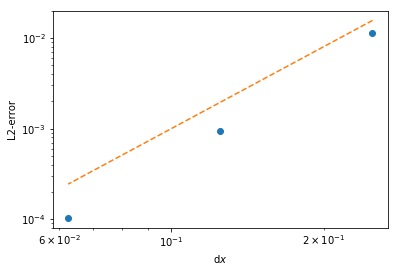

In [20]:
# check convergence
from scipy.integrate import fixed_quad

cases_e = 3

L2_error = np.zeros(cases_e)
h = np.zeros(cases_e)

for i in range(1, 1 + cases_e):
    
    Nel_x = 2*2**i
    Nel_y = 2*2**i
    Nel_z = 2*2**i
    
    el_b_x = np.linspace(0, Lx, Nel_x + 1)
    el_b_y = np.linspace(0, Ly, Nel_y + 1)
    el_b_z = np.linspace(0, Lz, Nel_z + 1)
    
    h[i - 1] = Lx/Nel_x

    # ... number of basis functions and knot vectors
    if bc == True:
        bcon = 1

        Nbase = [Nel_x + px, Nel_y + py, Nel_z + pz] 
        Nbase_x, Nbase_y, Nbase_z = Nbase

        Tx = inter.make_periodic_knots(px, Nbase_x)
        Ty = inter.make_periodic_knots(py, Nbase_y)
        Tz = inter.make_periodic_knots(pz, Nbase_z)
        T = [Tx, Ty, Tz]

        Nbase_x_0 = Nbase_x - px
        Nbase_y_0 = Nbase_y - py
        Nbase_z_0 = Nbase_z - pz

    else:
        bcon = 0

        Nbase = [Nel_x + px, Nel_y + py, Nel_z + pz] 
        Nbase_x, Nbase_y, Nbase_z = Nbase

        Tx = inter.make_open_knots(px, Nbase_x)
        Ty = inter.make_open_knots(py, Nbase_y)
        Tz = inter.make_open_knots(pz, Nbase_z)
        T = [Tx, Ty, Tz]

        Nbase_x_0 = Nbase_x - 2
        Nbase_y_0 = Nbase_y - 2
        Nbase_z_0 = Nbase_z - 2
        
    # ... discrete derivatives
    GRAD = der.GRAD_3d(p, Nbase, bc)

    M1 = integr.mass_matrix_V1(p, Nbase, T, bc)
    
    # ... assemble right-hand-side (L2 scalar product over the space V0) and apply boundary conditions
    rhs = integr.L2_prod_V0(model.f, p, Nbase, T)

    if bc == True:
        rhs[:px, :, :] += rhs[-px:, :, :]
        rhs[:, :py, :] += rhs[:, -py:, :]
        rhs[:, :, :pz] += rhs[:, :, -pz:]

        rhs = rhs[:rhs.shape[0] - px, :rhs.shape[1] - py, :rhs.shape[2] - pz]

    else:
        rhs = rhs[1:-1, 1:-1, 1:-1]

    # ... compute normalization of spline functions (only needed for periodic boundary conditions)
    if bc == True:
        norm = integr.normalization_V0(p, Nbase, T)

        norm[:px, :, :] += norm[-px:, :, :]
        norm[:, :py, :] += norm[:, -py:, :]
        norm[:, :, :pz] += norm[:, :, -pz:]

        norm = norm[:norm.shape[0] - px, :norm.shape[1] - py, :norm.shape[2] - pz]

    # ... assemble linear system
    zero = np.zeros((GRAD.transpose().dot(M1).shape[0], M1.dot(GRAD).shape[1]))
    mat = -GRAD.transpose().dot(M1)
    RHS = np.append(np.zeros(M1.shape[0]), np.reshape(rhs, Nbase_x_0*Nbase_y_0*Nbase_z_0))

    if bc == True:
        zero[-1] = np.reshape(norm, Nbase_x_0*Nbase_y_0*Nbase_z_0)
        zero = sparse.csr_matrix(zero)

        mat = mat.todense()
        mat[-1] = 0.
        mat = sparse.csr_matrix(mat)

        RHS[-1] = model.shift

    K = sparse.bmat([[M1, M1.dot(GRAD)], [mat, zero]], format='csr')

    # ... solve system
    res = sparse.linalg.spsolve(K, RHS)
    uvec = res[M1.shape[0]:]

    # ... compute L2-error
    diff = lambda x, y, z : (model.u(x, y, z) - eva.evaluate_field_V0(uvec, [np.array([x]), np.array([y]), np.array([z])], p, Nbase, T, bc))**2
    
    pts_x_loc, wts_x_loc = np.polynomial.legendre.leggauss(px)
    pts_y_loc, wts_y_loc = np.polynomial.legendre.leggauss(py)
    pts_z_loc, wts_z_loc = np.polynomial.legendre.leggauss(pz)
    
    pts_x, wts_x = inter.construct_quadrature_grid(Nel_x, px, pts_x_loc, wts_x_loc, el_b_x)
    pts_y, wts_y = inter.construct_quadrature_grid(Nel_y, py, pts_y_loc, wts_y_loc, el_b_y)
    pts_z, wts_z = inter.construct_quadrature_grid(Nel_z, pz, pts_z_loc, wts_z_loc, el_b_z)

    L2_error[i - 1] = np.sqrt(integr.integrate_3d([pts_x, pts_y, pts_z], [wts_x, wts_y, wts_z], diff).sum()) 
    print('L2-error =', L2_error[i - 1], ', degree =' , px, ', Nel =', Nel_x)

        
abzisse = np.array([10, 50, 100])
labels = ['$\sim \mathrm{d}x^3$', '$\sim \mathrm{d}x^4$', '$\sim  \mathrm{d}x^5$']
        

plt.loglog(h, L2_error, 'o')
plt.loglog(h, h**(px + 1), '--')


plt.xlabel('$\mathrm{d}x$')
plt.ylabel('L2-error')